<a href="https://colab.research.google.com/github/miyoonbell/GSIS/blob/main/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 汎用機械学習（AI）実行の目的
**Predict Future Sales のデータを用いて、特定の店舗、特定の商品カテゴリ、2016の特定の日時の、商品別売上個数を予測する。企業の本部セクションで営業支援職が行った予測値を各店舗の店長に対し自動送信し、次年度の売上目標、仕入れ計画、アルバイト雇用の予測値を提示し、現場運営の計画、実行に活かしてもらう。全データを用いて学習後、shop_idとitem_category_id、そして特定の年月日を指定して、商品別に売上個数の高い順から一覧で出力する、という処理を行う。学習用データと訓練用データを結合し、土日祝の情報を加えて、特徴量エンジニアリングを行い、汎用機械学習モデル（LightGBMを想定、XGBoostも視野に）を実行する**

Analyze the "Predict Future Sales" dataset to predict item sales for specific shops and item categories on a given date in 2016, using a machine learning model trained on the entire dataset. The final output should be a list of items sorted by predicted sales quantity for the specified shop, item category, and date. The analysis should include data cleaning, feature engineering (including time-related features like day of the week and holidays for Russia), model training (considering LightGBM and XGBoost), prediction, and evaluation.


**以下、英文のコメントと、ReasoningはGeminiが生成したアドバイス。**
**＃付コメントと太字コメントは、自分で補足したもの**

#初期宣言、インストール


In [1]:
!pip install hvplot

import pandas
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from sklearn.impute import KNNImputer
pandas.__version__

#ワードクラウド
from wordcloud import WordCloud
from wordcloud import STOPWORDS
#参照
#https://github.com/ksk-portfolio/data_analytics/blob/master/Predict_Future_Sales.ipynb

# ロシアの祝日情報を取得するために 'holidays' ライブラリをインストール
!pip install holidays
import holidays

import lightgbm as lgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.8 MB/s eta 0:00:00


#データ読み込み
Provided data description

1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
2. test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
3. sample_submission.csv - a sample submission file in the correct format.
4. items.csv - supplemental information about the items/products.
5. item_categories.csv - supplemental information about the items categories.
6. shops.csv- supplemental information about the shops.


In [2]:
#データ読み込み
#商品カテゴリマスタ
df_cats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Predict Future Sales/item_categories_j.csv', encoding="utf-8")
#売上商品マスタ
df_item = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Predict Future Sales/item_j.csv', encoding="utf-8")
df_item = df_item.drop("item_name", axis=1)
#店舗マスタ
df_shops = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Predict Future Sales/shops_j.csv', encoding="utf-8")
#学習用データ
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Predict Future Sales/sales_train.csv', encoding="utf-8")
#評価用データ set index to ID to avoid droping it later
df_test  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Predict Future Sales/test.csv').set_index('ID')

#コンペの提出データのサンプル sample_submission.csv
#今回の結果の出力　submission.csv

#EDA 探索的データ分析 (Exploratory Data Analysis)

(1)商品カテゴリ

In [3]:
df_cats.head()

,item_category_name,item_category_id
0,PC - ヘッドセット/ヘッドホン,0
1,アクセサリー - PS2,1
2,アクセサリー - PS3,2
3,アクセサリー - PS4,3
4,アクセサリー - PSP,4


In [4]:
df_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df_cats.describe()
#IDは0から83の整数値

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [6]:
df_cats.isnull().sum()
#欠損値なし

,0
item_category_name,0
item_category_id,0


In [7]:
#df_train, df_item, df_catsを結合
df_merged = pd.merge(df_train, df_item, on='item_id', how='left')
df_merged = pd.merge(df_merged, df_cats, on='item_category_id', how='left')

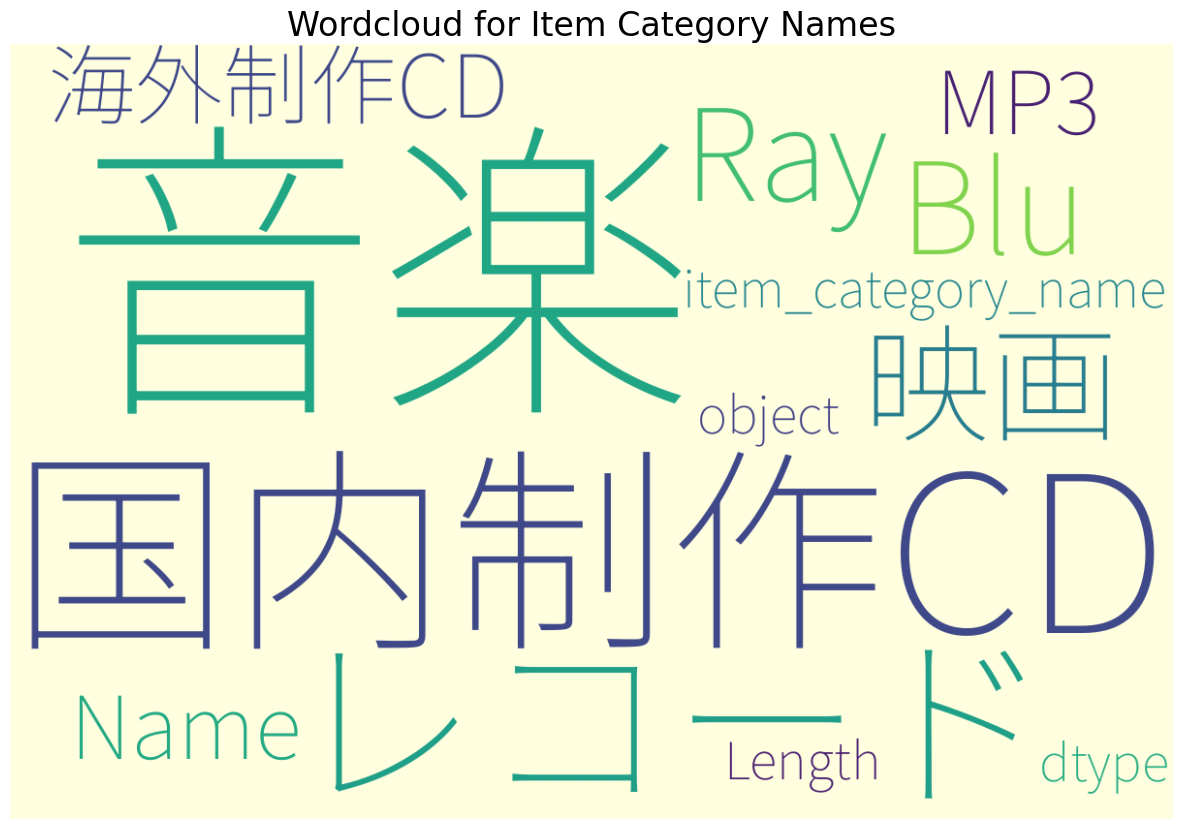

In [8]:
#実際の売上履歴から商品分類名の全体的傾向をワードクラウドで確認
#日本語が豆腐にならないようにフォント定義ファイルのパスを指定
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightyellow',
                      max_words = 200,
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     font_path='/content/drive/MyDrive/Colab Notebooks/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf',
                     random_state = 42).generate(str(df_merged['item_category_name']))


plt.title('Wordcloud for Item Category Names', fontsize = 24)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')
#音楽やゲームソフト、小説などを販売しているTSUTAYAのようなチェーン店とわかる

(2)商品名

In [9]:
df_item
#22169件の商品アイテム

,item_id,item_category_id,item_name_jp
0,0,40,幻影の力で (プラスト.) D
1,1,76,ABBYY FineReader 12 Professional Edition Full ...
2,2,40,栄光の光の中で (UNV) D
3,3,40,青い波 (ユニヴ) D
4,4,40,箱 (ガラス) D
...,...,...,...
22165,22165,31,ニュークリアー・ティットビット2 [PC、デジタル版]
22166,22166,54,1C：エンタープライズのクエリ言語 [デジタル版]
22167,22167,49,1C：エンタープライズ8のクエリ言語 (+CD). フルスタレヴァ E.Y.
22168,22168,62,リトル・イヌのための卵


In [10]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_id           22170 non-null  int64 
 1   item_category_id  22170 non-null  int64 
 2   item_name_jp      22170 non-null  object
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [11]:
df_item.describe()
#欠損値はなし、カテゴリIDも0～83までの値が入っており、異常値は見当たらない

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [12]:
#すべてのアイテムに数字が降られている
df_item.isnull().sum()

,0
item_id,0
item_category_id,0
item_name_jp,0


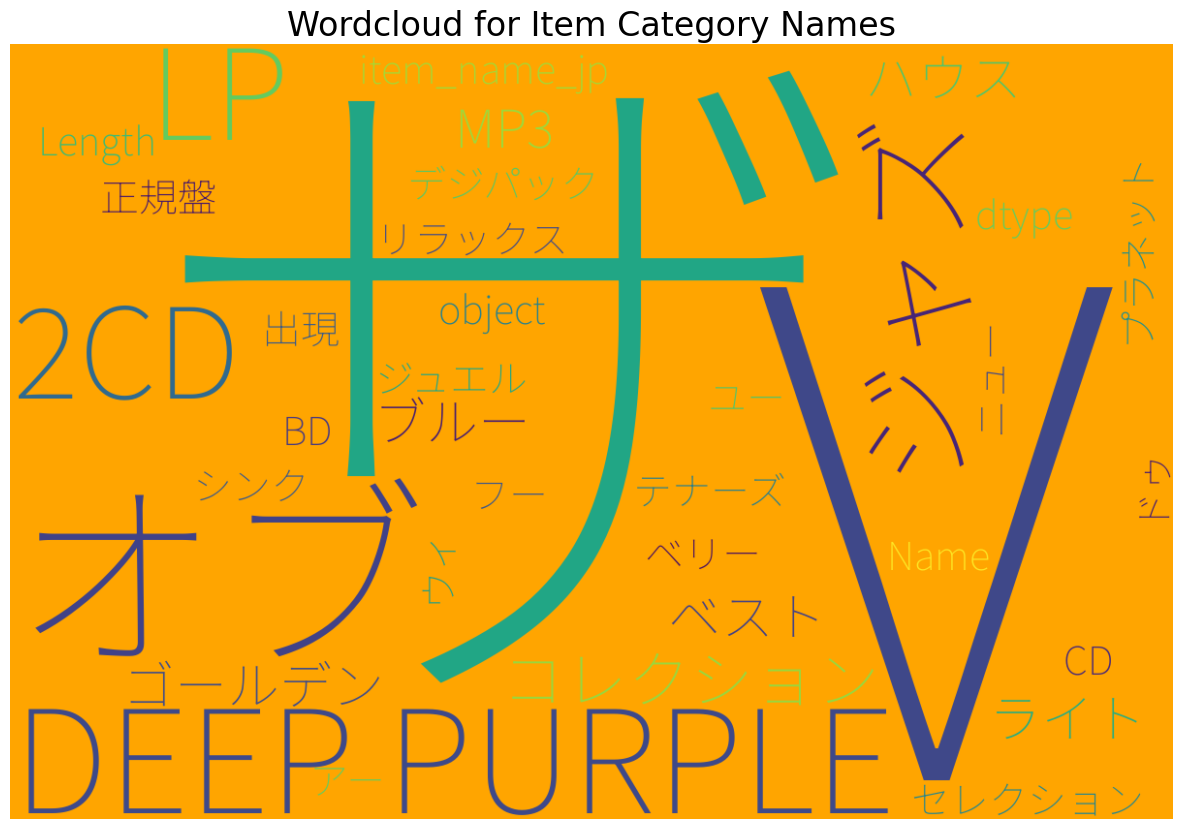

In [13]:
#実際の売上履歴から商品名の全体的傾向をワードクラウドで確認
#日本語が豆腐にならないようにフォントをダウンロードしてパス指定
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'orange',
                      max_words = 200,
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     font_path='/content/drive/MyDrive/Colab Notebooks/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf',
                     random_state = 42).generate(str(df_merged['item_name_jp']))


plt.title('Wordcloud for Item Category Names', fontsize = 24)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

In [14]:
#カテゴリ別の商品数を確認
# item_category_idごとにitem_idの数をカウント
item_count_by_category = df_item.groupby('item_category_id')['item_id'].count()

# item_category_idの昇順にソートして表示
#カウント数にかなりのばらつきが見られる
display(item_count_by_category.sort_index())

,item_id
item_category_id,
0,4
1,2
2,75
3,34
4,15
5,29
6,40
7,24
8,9


(3)店舗名

In [15]:
df_shops.head()

,shop_name,shop_id
0,ヤクーツク オルジョニキゼ通り56番地 フランチャイズ,0
1,ヤクーツク ショッピングセンター「セントラル」フランチャイズ,1
2,アディゲア ショッピングセンター「メガ」,2
3,バラシハ ショッピング＆レジャー複合施設「オクトヤブリ＝キノミール」,3
4,ヴォルシスキー ショッピングセンター「ヴォルガモール」,4


In [16]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [17]:
#店舗マスタも欠損値はない
df_shops.isnull().sum()


,0
shop_name,0
shop_id,0


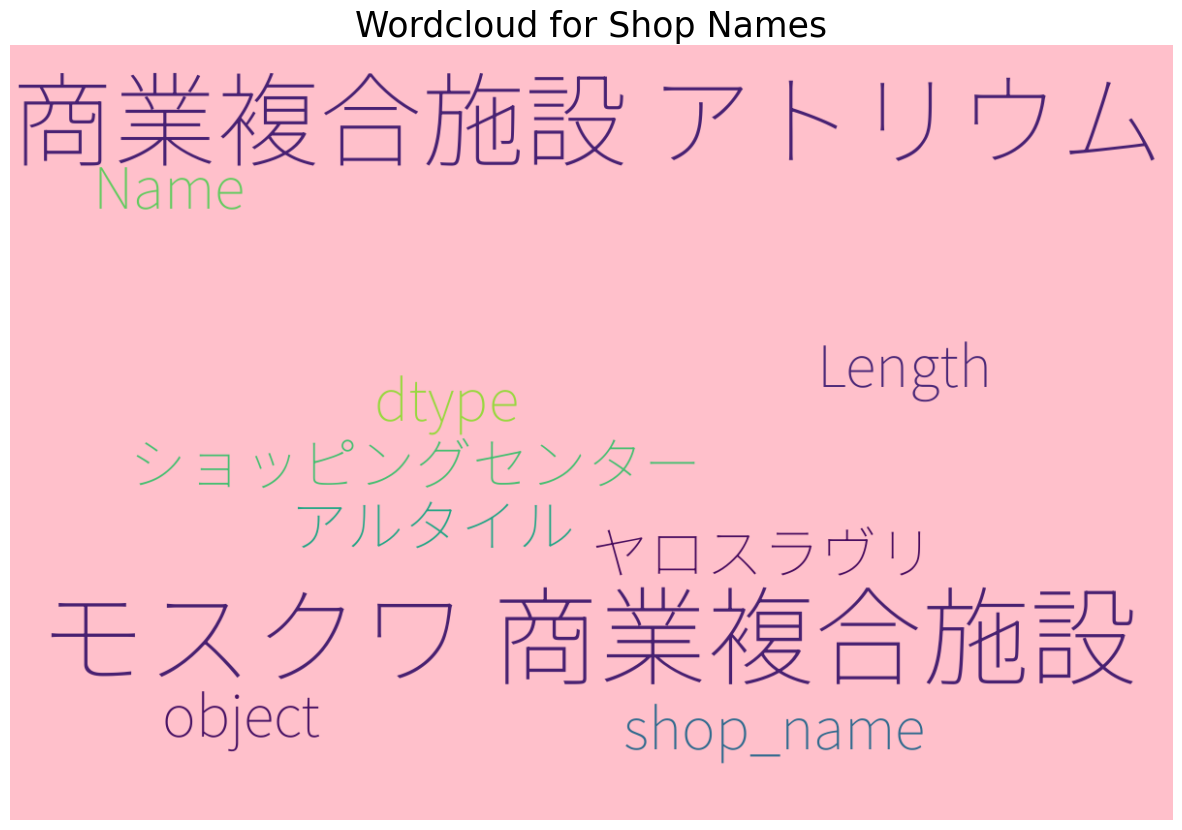

In [18]:
# df_merged と df_shops を結合
df_merged = pd.merge(df_merged, df_shops, on='shop_id', how='left')

#売上履歴からショップ名の傾向を確認
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink',
                      max_words = 200,
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     font_path='/content/drive/MyDrive/Colab Notebooks/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf',
                     random_state = 42).generate(str(df_merged['shop_name']))

plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')
#ショッピングセンター、複合施設にある店舗が多い模様

（4）学習用データ(train)




In [19]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [21]:
df_train.describe()
#item_price item_cnt_dayに負の値が含まれる

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [22]:
df_train.isnull().sum()

,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0


(5) 検証用データ(test)

In [23]:
#フィールドはIDのみ
df_test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [24]:
df_test.isnull().sum()

,0
shop_id,0
item_id,0


In [25]:
#学習用(df_train)と評価用(df_test)データに含まれる店舗数、商品数を確認
#マスタ(df_item、df_shopsにある)ではitem 22170 shops 60
#今回のAI実行では全ての商品、店舗の予測ができないことを知っておく
print("Unique shop_id in df_train:", df_train['shop_id'].nunique())
print("Unique item_id in df_train:", df_train['item_id'].nunique())
print("\nUnique shop_id in df_test:", df_test['shop_id'].nunique())
print("Unique item_id in df_test:", df_test['item_id'].nunique())

Unique shop_id in df_train: 60
Unique item_id in df_train: 21807

Unique shop_id in df_test: 42
Unique item_id in df_test: 5100


In [26]:
# df_merged から item_price が最大値の行を特定
max_price_item = df_merged.loc[df_merged['item_price'].idxmax()]
radmin_records = df_merged[df_merged['item_name_jp'] == "Radmin 3 - 522ライセンス"]
display(radmin_records)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name_jp,item_category_name,shop_name
1163158,13.12.2013,11,12,6066,307980.0,1.0,75,Radmin 3 - 522ライセンス,ソフトウェア - 家庭・オフィス用,オンラインストア「ЧС」


# データ可視化

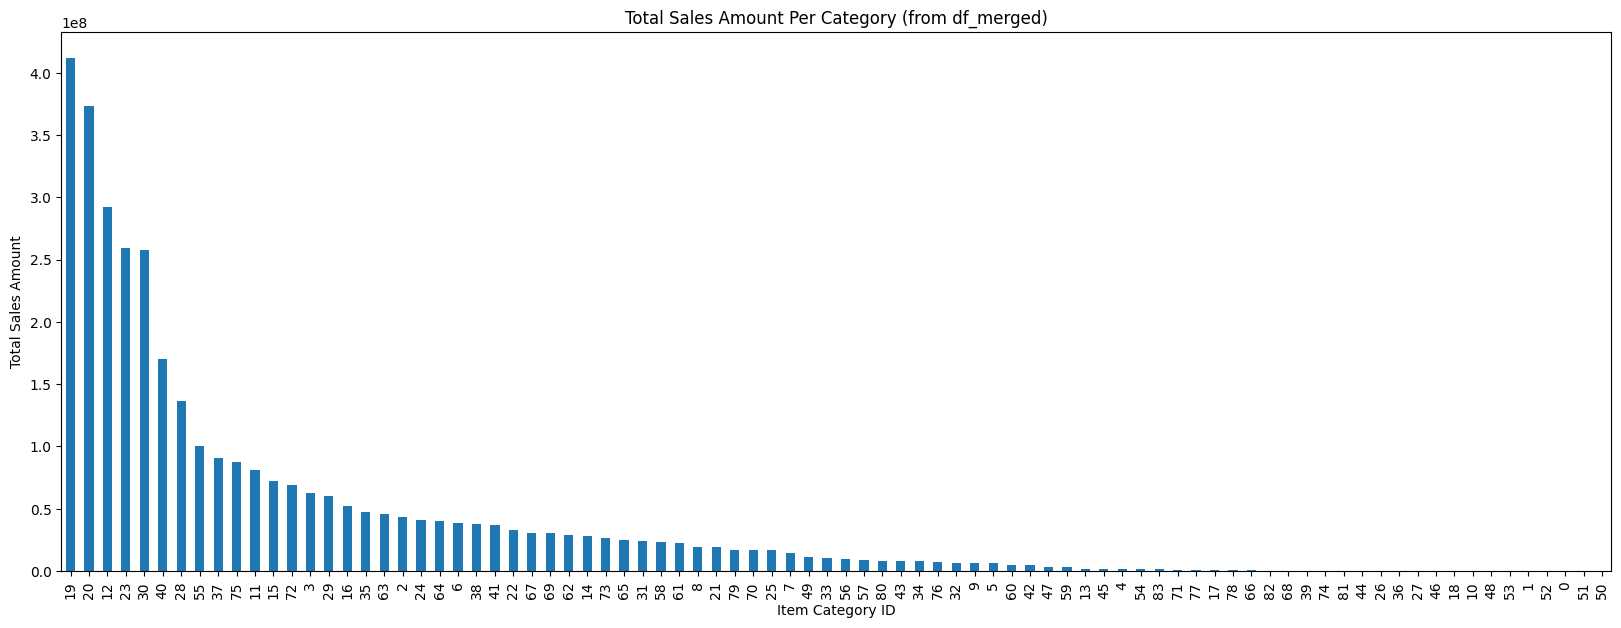

In [27]:
# df_mergedに販売合計額の列を追加
df_merged['total_price'] = df_merged['item_price'] * df_merged['item_cnt_day']

# category_id別に販売合計額をカウント
sales_amount_by_category = df_merged.groupby('item_category_id')['total_price'].sum()


# 販売合計額の大きい順にソート
sales_amount_by_category = sales_amount_by_category.sort_values(ascending=False)

# 結果を棒グラフで表示
plt.figure(figsize=(20, 7))
sales_amount_by_category.plot(kind='bar')
plt.title('Total Sales Amount Per Category (from df_merged)')
plt.xlabel('Item Category ID')
plt.ylabel('Total Sales Amount')
plt.show()

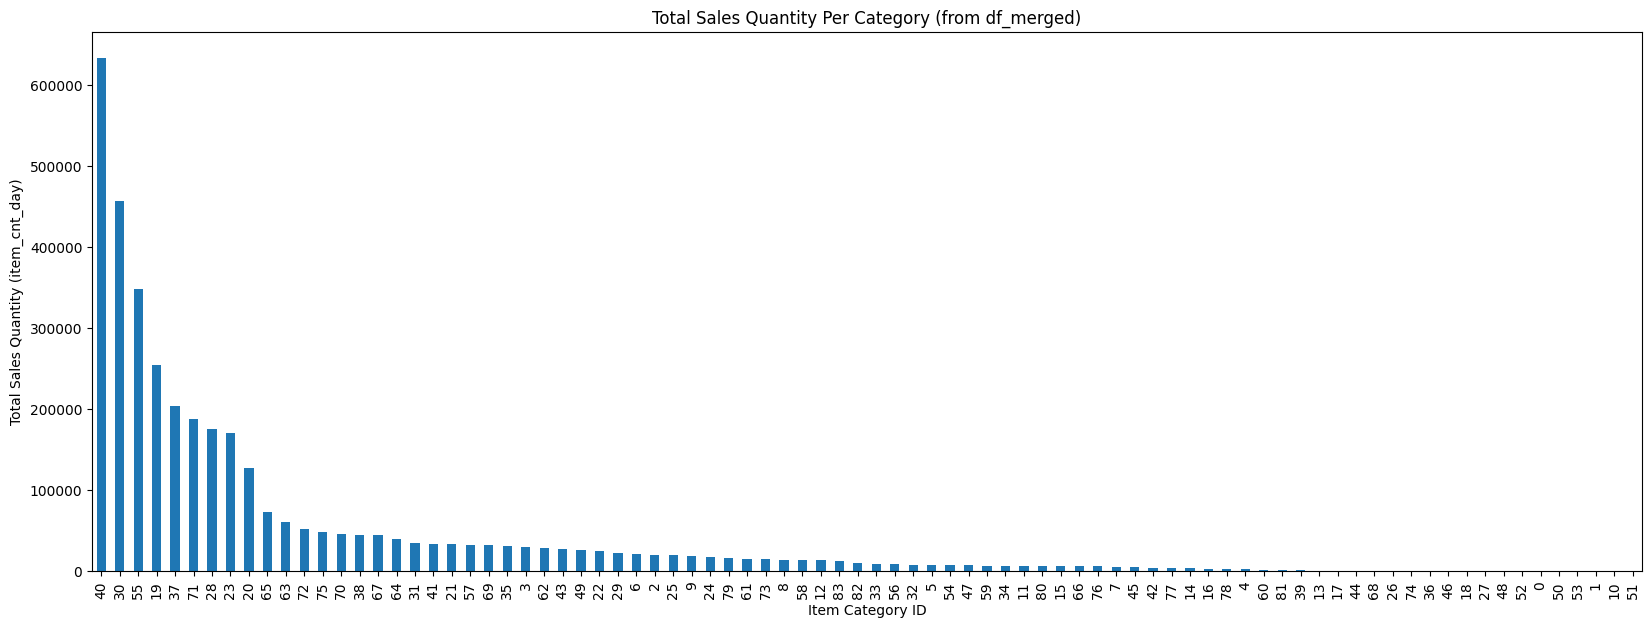

In [28]:
# df_mergedデータで、category_id別に販売個数 (item_cnt_day の合計) をカウント
sales_by_category_merged = df_merged.groupby('item_category_id')['item_cnt_day'].sum()

# 販売個数の多い順にソート
sales_by_category_merged = sales_by_category_merged.sort_values(ascending=False)

# 結果を棒グラフで表示
plt.figure(figsize=(20, 7))
sales_by_category_merged.plot(kind='bar')
plt.title('Total Sales Quantity Per Category (from df_merged)')
plt.xlabel('Item Category ID')
plt.ylabel('Total Sales Quantity (item_cnt_day)')
plt.show()

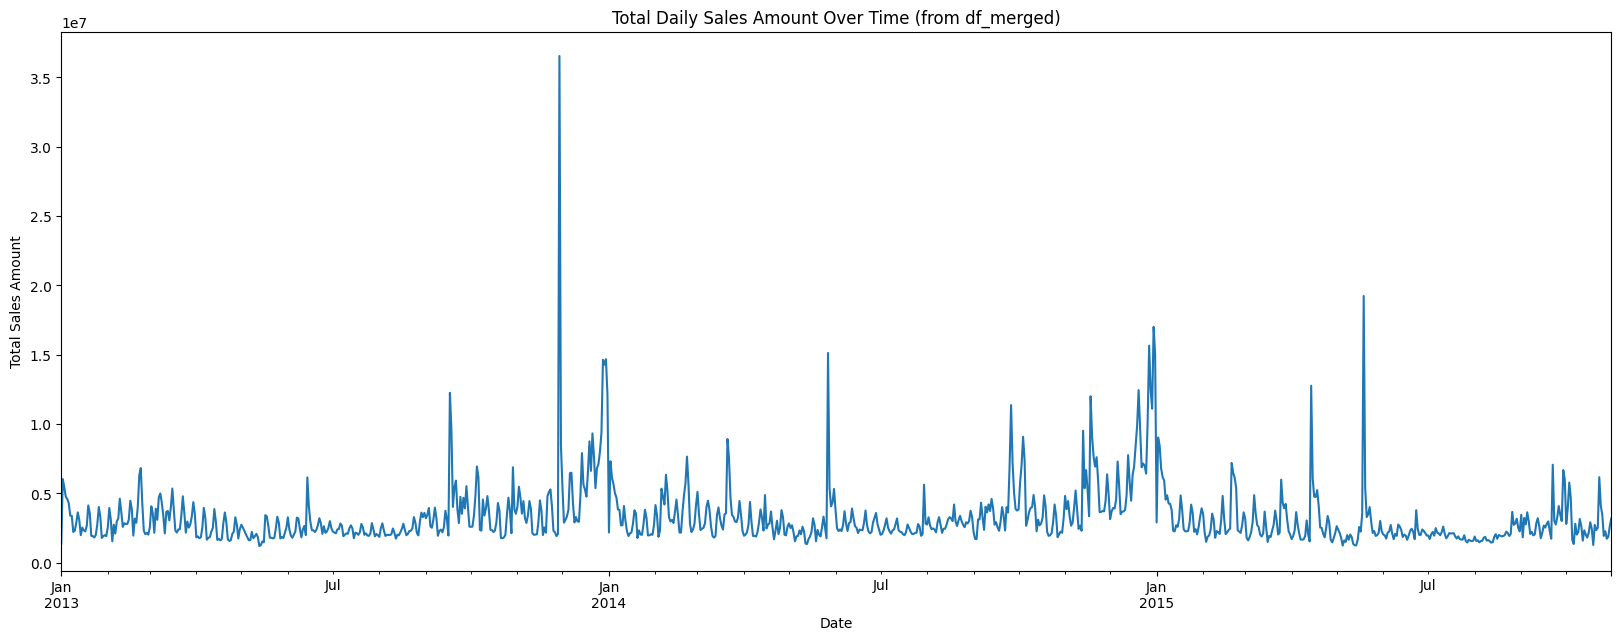

In [29]:
# 'date'列をdatetimeオブジェクトに変換
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%d.%m.%Y')
# 日付ごとに総売上金額を集計
daily_sales_amount = df_merged.groupby('date')['total_price'].sum()

# 時系列の折れ線グラフで表示
#5月下旬の特定の日、11月から12月にかけての年末期間に売り上げのピークがあり。
plt.figure(figsize=(20, 7))
daily_sales_amount.plot()
plt.title('Total Daily Sales Amount Over Time (from df_merged)')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

In [30]:
# 'date'列をdatetimeオブジェクトに変換 (すでにdatetime型の場合は再度実行しても問題ありません)
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%d.%m.%Y')

# 'date'列から曜日情報を抽出 (月曜日=0, 日曜日=6)
df_merged['dayofweek'] = df_merged['date'].dt.dayofweek


In [31]:
# ロシアの祝日を取得
# データ期間は 2013年から2015年までなので、これらの年の祝日を取得します
ru_holidays = holidays.RU(years=[2013, 2014, 2015])

# 'is_holiday' 列を追加 (祝日なら 1, それ以外は 0)
df_merged['is_holiday'] = df_merged['date'].apply(lambda date: 1 if date in ru_holidays else 0)

# 結果の確認
display(df_merged.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name_jp,item_category_name,shop_name,total_price,dayofweek,is_holiday
0,2013-01-02,0,59,22154,999.00,1.0,37,出現 2012 (BD),映画 - Blu-Ray,ヤロスラヴリ ショッピングセンター「アルタイル」,999.00,2,1
1,2013-01-03,0,25,2552,899.00,1.0,58,DEEP PURPLE ザ・ハウス・オブ・ブルー・ライト LP,音楽 - レコード,モスクワ 商業複合施設「アトリウム」,899.00,3,1
2,2013-01-05,0,25,2552,899.00,-1.0,58,DEEP PURPLE ザ・ハウス・オブ・ブルー・ライト LP,音楽 - レコード,モスクワ 商業複合施設「アトリウム」,-899.00,5,1
3,2013-01-06,0,25,2554,1709.05,1.0,58,DEEP PURPLE フー・ドゥ・ユー・シンク・ウィ・アー LP,音楽 - レコード,モスクワ 商業複合施設「アトリウム」,1709.05,6,1
4,2013-01-15,0,25,2555,1099.00,1.0,56,DEEP PURPLE 30 ベリー・ベスト・オブ 2CD (正規盤),音楽 - 海外制作CD,モスクワ 商業複合施設「アトリウム」,1099.00,1,0


<Figure size 2000x700 with 0 Axes>

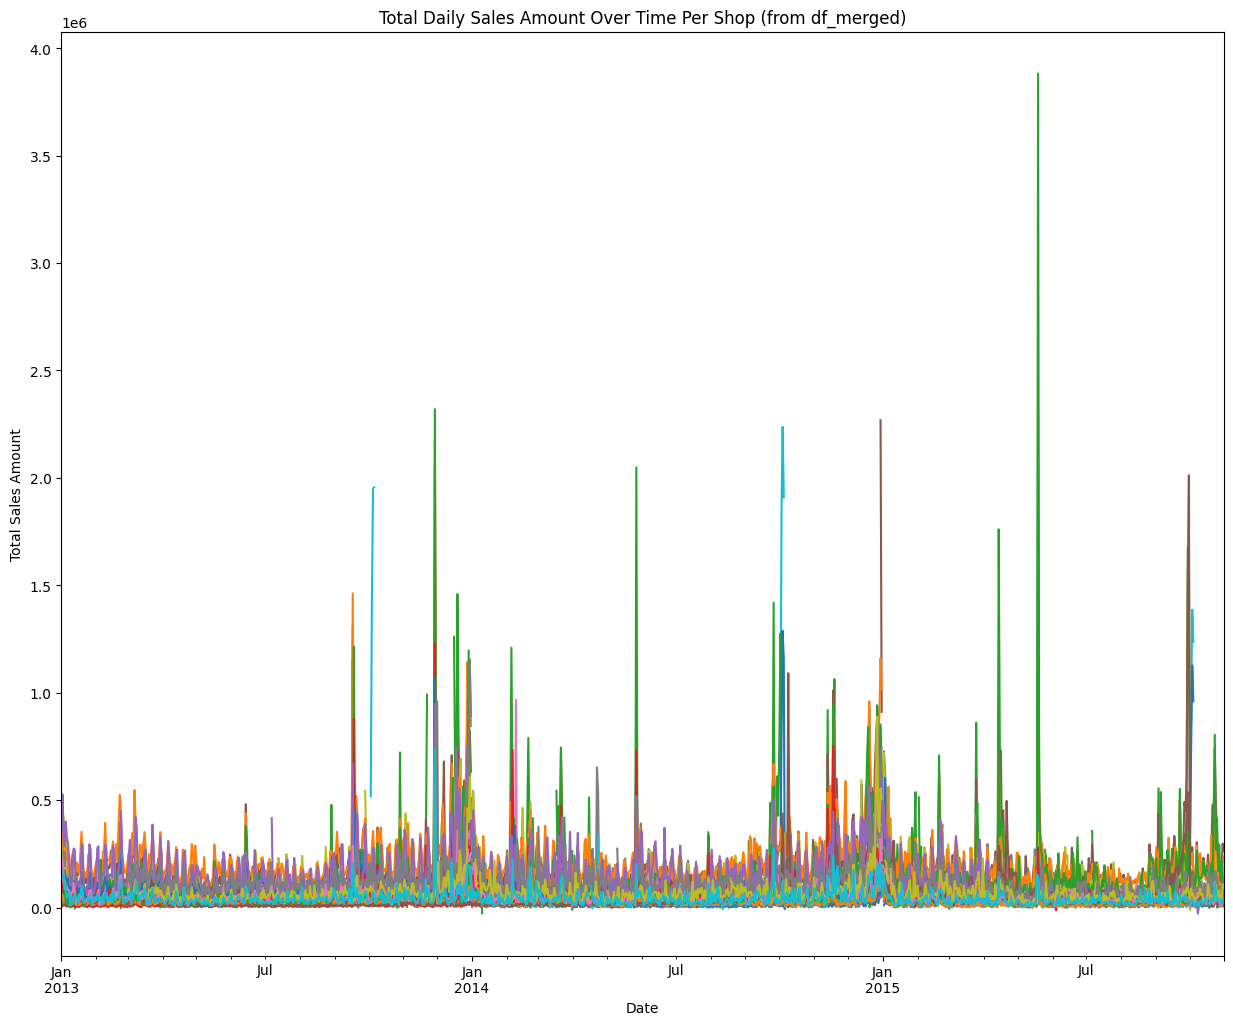

In [32]:
# 日付と店舗ごとに総売上金額を集計
daily_sales_amount_by_shop = df_merged.groupby(['date', 'shop_id'])['total_price'].sum()

# 結果を整形（unstack）して、時系列グラフの形にする
daily_sales_amount_by_shop_unstacked = daily_sales_amount_by_shop.unstack(level='shop_id')

# 時系列の折れ線グラフで表示
plt.figure(figsize=(20, 7))
daily_sales_amount_by_shop_unstacked.plot(legend=False) # legend=False で凡例を非表示にして見やすくする
plt.title('Total Daily Sales Amount Over Time Per Shop (from df_merged)')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

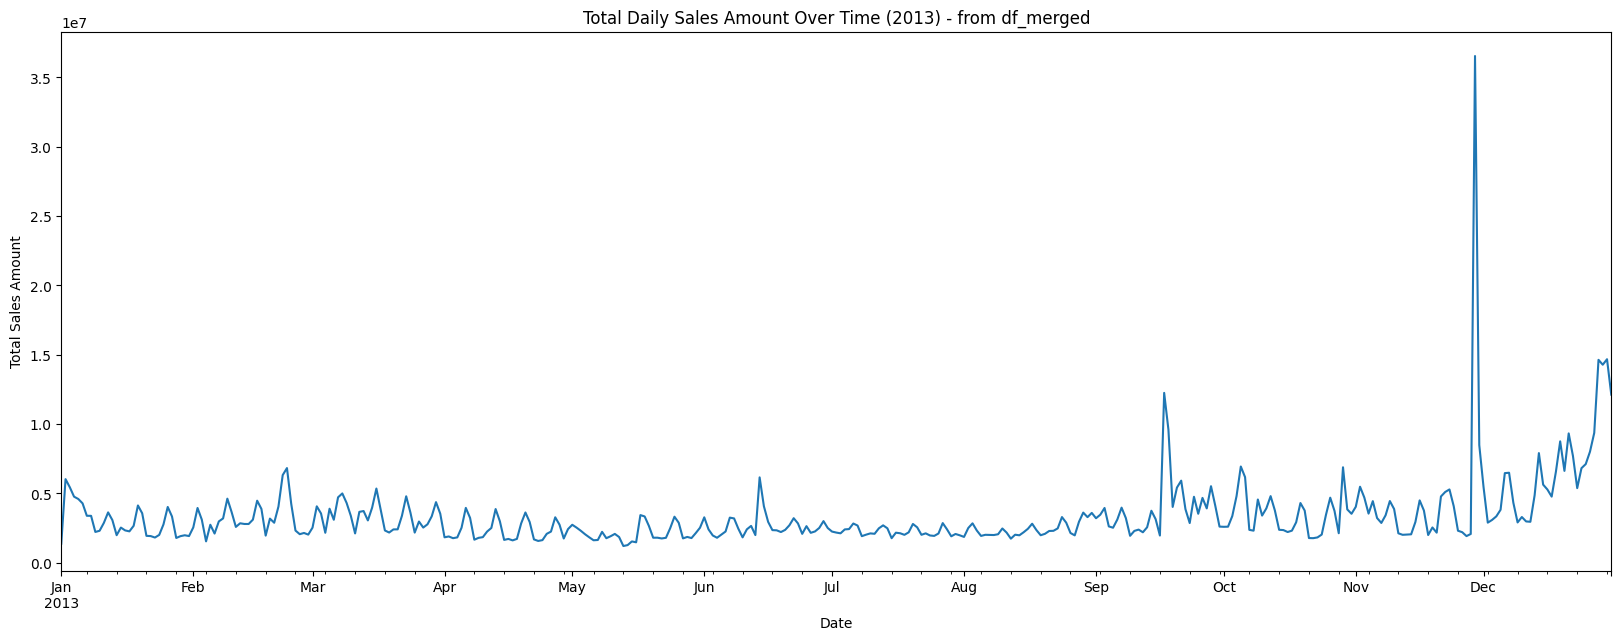

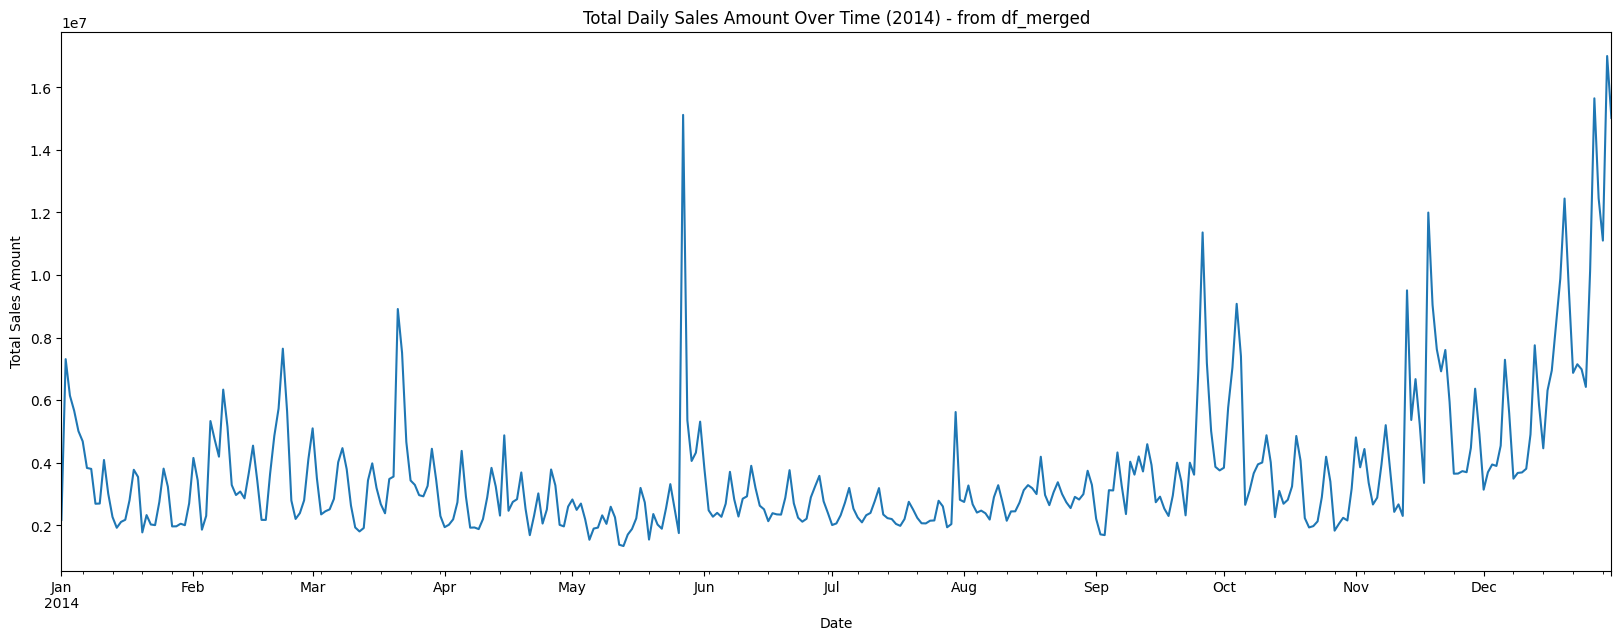

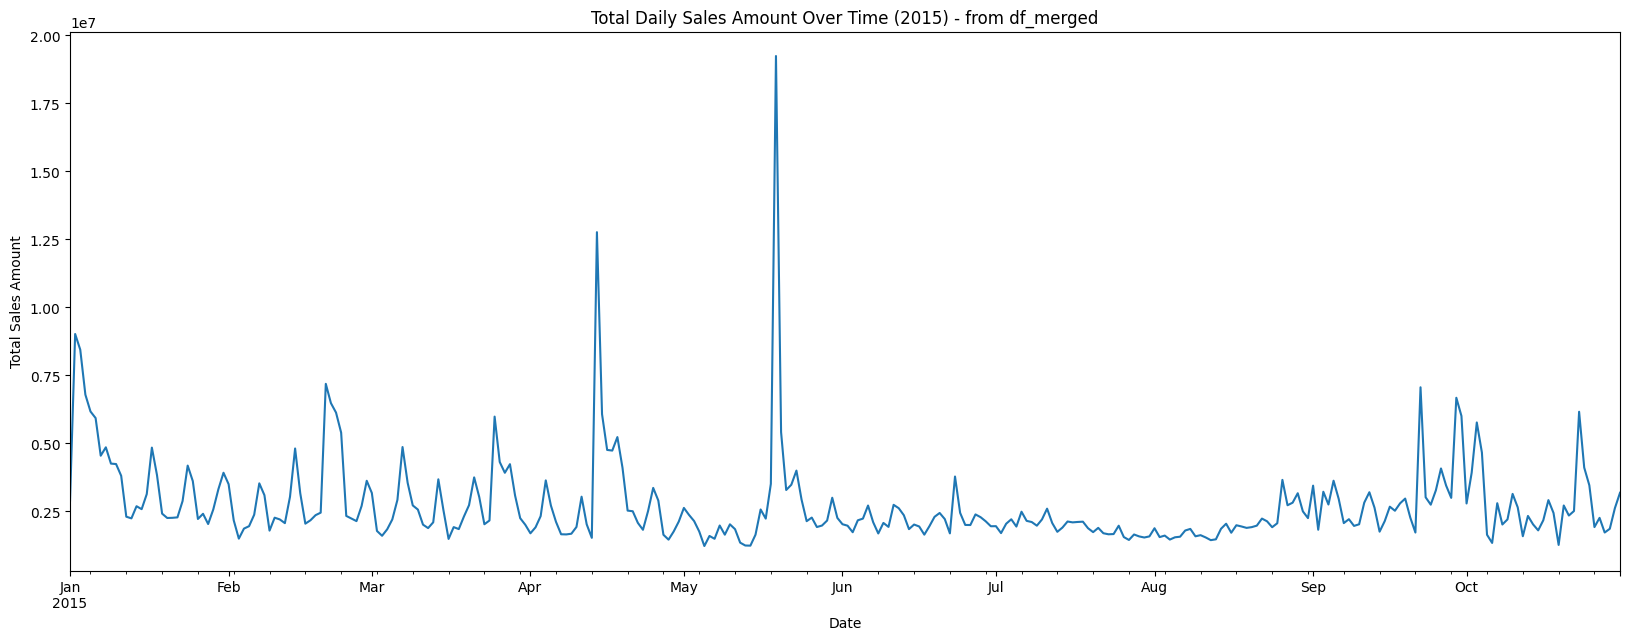

In [33]:
# 2013年のデータでフィルタリングし、時系列の折れ線グラフで表示
daily_sales_2013 = daily_sales_amount[daily_sales_amount.index.year == 2013]
plt.figure(figsize=(20, 7))
daily_sales_2013.plot()
plt.title('Total Daily Sales Amount Over Time (2013) - from df_merged')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

# 2014年のデータでフィルタリングし、時系列の折れ線グラフで表示
daily_sales_2014 = daily_sales_amount[daily_sales_amount.index.year == 2014]
plt.figure(figsize=(20, 7))
daily_sales_2014.plot()
plt.title('Total Daily Sales Amount Over Time (2014) - from df_merged')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

# 2015年のデータでフィルタリングし、時系列の折れ線グラフで表示
daily_sales_2015 = daily_sales_amount[daily_sales_amount.index.year == 2015]
plt.figure(figsize=(20, 7))
daily_sales_2015.plot()
plt.title('Total Daily Sales Amount Over Time (2015) - from df_merged')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.show()

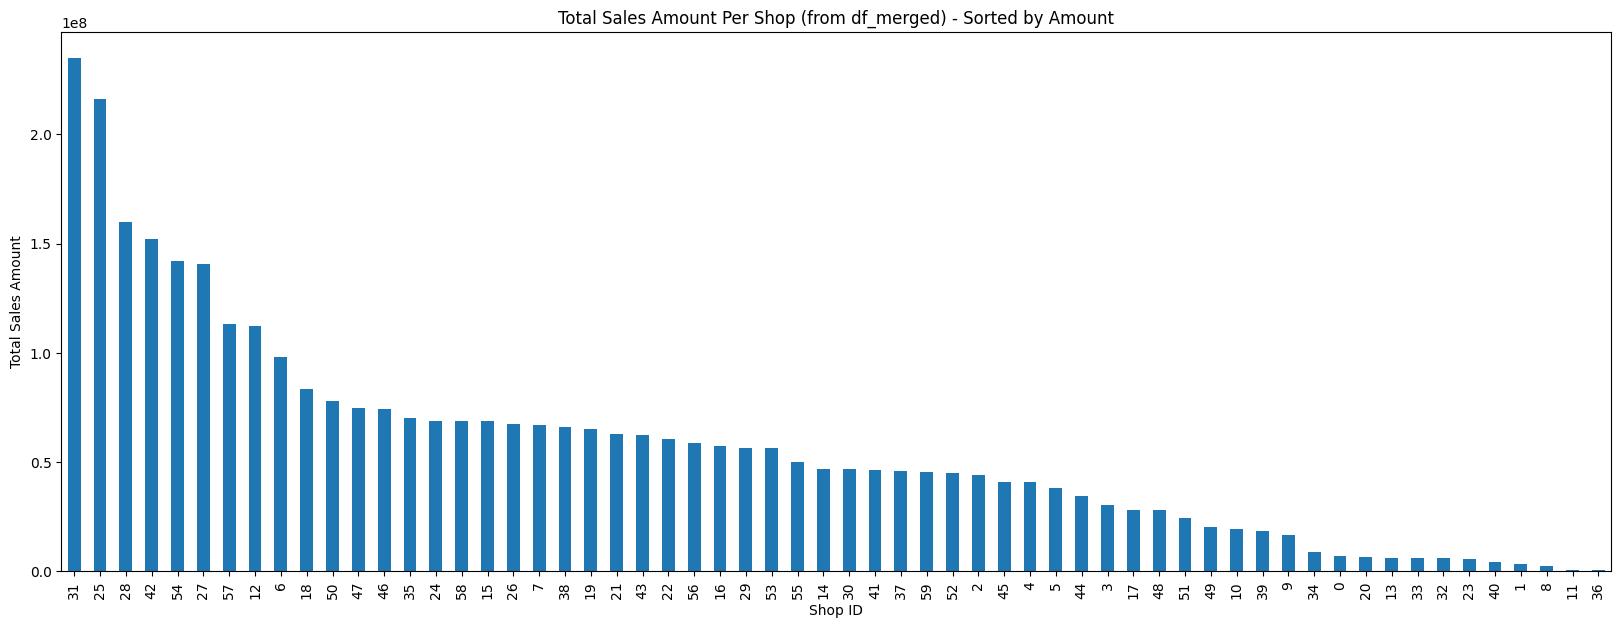

In [34]:
# df_mergedデータで、shops_id別に販売合計額をカウント
sales_amount_by_shop = df_merged.groupby('shop_id')['total_price'].sum()

# 販売合計額の大きい順にソート
sales_amount_by_shop = sales_amount_by_shop.sort_values(ascending=False)

# 結果を棒グラフで表示
plt.figure(figsize=(20, 7))
sales_amount_by_shop.plot(kind='bar')
plt.title('Total Sales Amount Per Shop (from df_merged) - Sorted by Amount')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales Amount')
plt.show()

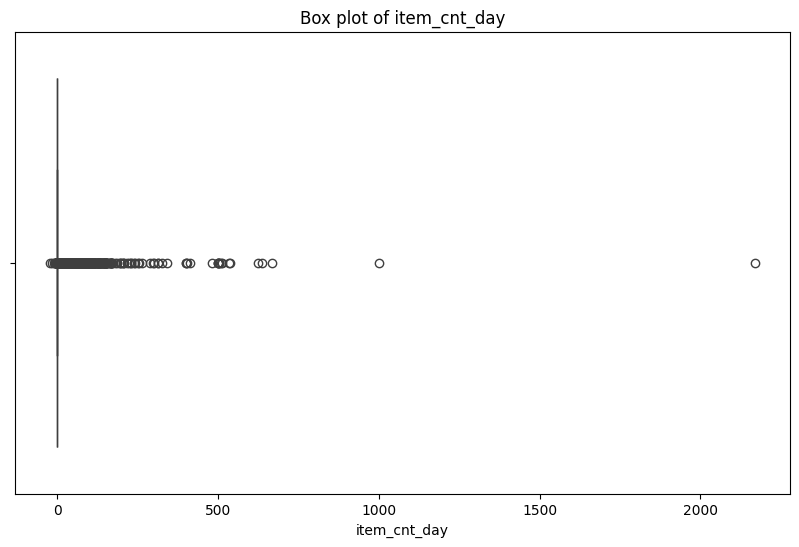

In [35]:
# 箱ひげ図で外れ値を確認
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['item_cnt_day'])
plt.title('Box plot of item_cnt_day')
plt.xlabel('item_cnt_day')
plt.show()

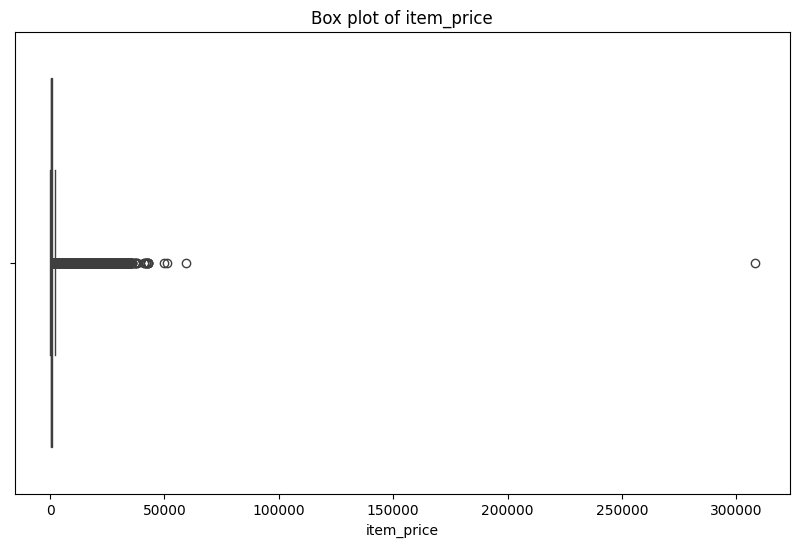

In [36]:
# 商品価格　箱ひげ図で外れ値を確認
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['item_price'])
plt.title('Box plot of item_price')
plt.xlabel('item_price')
plt.show()

In [37]:
# 店舗と商品ごとに販売数を合計し、多い順に並べ替え
best_selling_items = df_train.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().sort_values(ascending=False)

# 結果を表示
print("店舗・商品ごとの合計販売数 (よく売れている順)　マイナスは返品:")
display(best_selling_items)

店舗・商品ごとの合計販売数 (よく売れている順)　マイナスは返品:


,,item_cnt_day
shop_id,item_id,
31,20949,19934.0
25,20949,14343.0
28,20949,13458.0
54,20949,12323.0
42,20949,10514.0
...,...,...
16,13477,-1.0
44,13419,-1.0
59,13501,-1.0


,item_cnt_day
shop_id,
31,310777.0
25,241920.0
54,185790.0
28,184557.0
42,144934.0
57,141107.0
27,136657.0
6,100489.0
58,81734.0


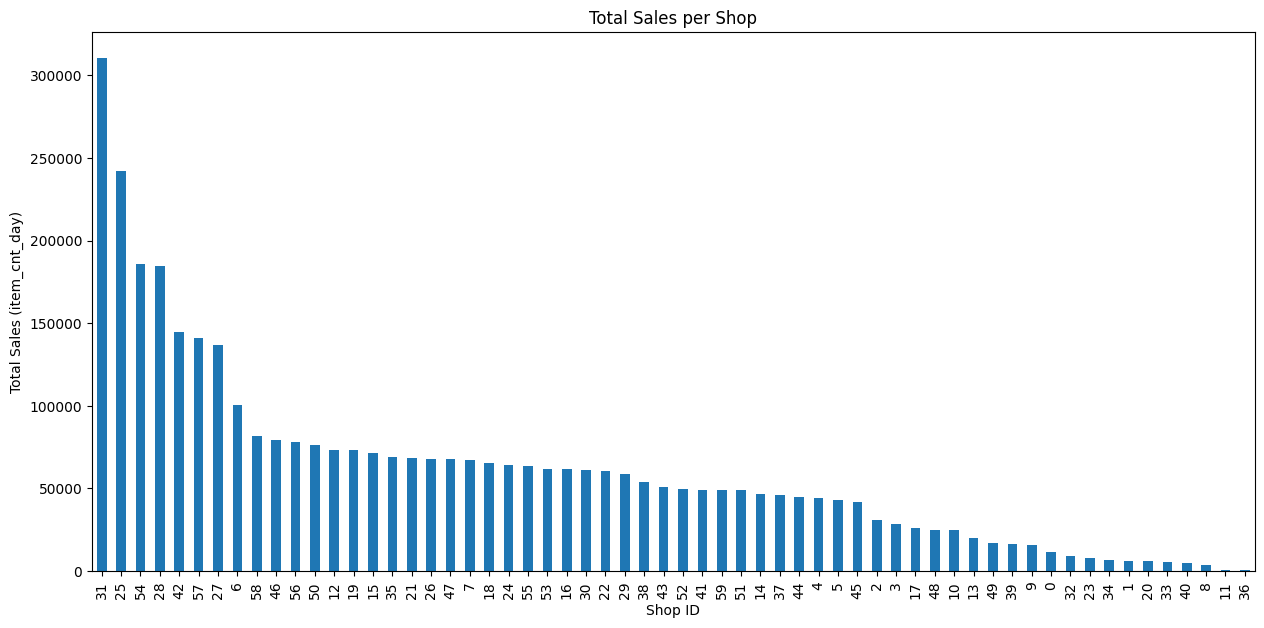

In [38]:
# 店舗ごとの合計販売数を計算
sales_by_shop = df_train.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)

# 結果を表示
display(sales_by_shop)

# 店舗ごとの合計販売数を棒グラフで可視化
plt.figure(figsize=(15, 7))
sales_by_shop.plot(kind='bar')
plt.title('Total Sales per Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales (item_cnt_day)')
plt.show()

## データクレンジング

### Subtask:
外れ値や異常値の処理



**Reasoning**:

---


Remove rows with outlier values in 'item_cnt_day' and 'item_price' from df_train as per the subtask instructions.




In [39]:
#item_cnt_dayとitem_priceの極大値を取りのぞく
df_train = df_train[df_train['item_cnt_day'] < 1000].copy()
df_train = df_train[df_train['item_price'] < 300000].copy()
#負の値を欠損値(NaN)に置き換える
df_train.loc[df_train['item_cnt_day'] < 0, 'item_cnt_day'] = np.nan
df_train.loc[df_train['item_price'] < 0, 'item_price'] = np.nan
#欠損値（NaN）を K近傍法 (k-nearest neighbors, KNN) を使って補完する手法を実行
knn_imputer = KNNImputer(n_neighbors=2)
df_train[['item_cnt_day', 'item_price']] = knn_imputer.fit_transform(df_train[['item_cnt_day', 'item_price']])

## 月ごとの集計

### Subtask:
月ごと、店舗ごと、商品ごとに販売数などの情報を集計し、月次の粒度でデータを扱えるようにします。

**Reasoning**:
Concatenate df_train and df_test and add the date_block_num column to df_test for the test set, then group the concatenated dataframe by date_block_num, shop_id, and item_id, calculating the sum of item_cnt_day and the mean of item_price. Store these results in a new dataframe df_train_test with specified column names.



In [40]:
#df_testに予測対象月のインデックス（34）（2015 年 11 月）を付与し、訓練データとテストデータを統合しdf_train_test 作成
#各種ユニークIDでグループ化
df_test['date_block_num'] = 34

df_train_test = pd.concat([df_train, df_test], ignore_index=True)
df_train_test = df_train_test.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg(
    item_cnt_month=('item_cnt_day', 'sum'),
    item_price_avg=('item_price', 'mean')
)
display(df_train_test.head())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_avg
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


## 特徴量エンジニアリング

### Subtask:
集計データから、ラグ特徴量（過去数ヶ月の販売数など）、時間関連特徴量（月、年、曜日など）、価格関連特徴量、商品カテゴリ関連特徴量など、予測に役立つ可能性のある特徴量を作成します。

**ラグ特徴量：現在のデータ点を予測するために、過去のデータポイントをそのまま説明変数（特徴量）として利用する方法**


**Reasoning**:
Merge df_train_test with df_item and df_cats to add item category information and then create lag features for item_cnt_month, add time-related features (month, year) and fill missing values in the lag features with 0.



In [41]:
# 1. df_train_test と df_item を item_id をキーとして結合し、商品カテゴリ情報を追加
df_train_test = pd.merge(df_train_test, df_item[['item_id', 'item_category_id']], on='item_id', how='left')

# 2. df_train_test と df_cats を item_category_id をキーとして結合し、商品カテゴリ名を追加
df_train_test = pd.merge(df_train_test, df_cats[['item_category_id', 'item_category_name']], on='item_category_id', how='left')

# 3. ラグ特徴量として、過去1ヶ月、2ヶ月、3ヶ月の item_cnt_month を追加
# ラグ特徴量は date_block_num、shop_id、item_id ごとに計算
for i in [1, 2, 3]:
    df_train_test[f'item_cnt_month_lag_{i}'] = df_train_test.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(i)

# 4. 時間関連特徴量として月の情報（month）、年の情報（year）を追加
df_train_test['month'] = df_train_test['date_block_num'] % 12
df_train_test['year'] = (df_train_test['date_block_num'] / 12).astype(int) + 2013

# 5. ラグ特徴量の欠損値を0で埋める
df_train_test.fillna(0, inplace=True)

# 6. 結果の確認
display(df_train_test.head())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_avg,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,month,year
0,0,0,32,6.0,221.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
1,0,0,33,3.0,347.0,37,映画 - Blu-Ray,0.0,0.0,0.0,0,2013
2,0,0,35,1.0,247.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
3,0,0,43,1.0,221.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
4,0,0,51,2.0,128.5,57,音楽 - MP3,0.0,0.0,0.0,0,2013


## データセットの分割

### Subtask:
モデルの訓練と評価のために、データセットを訓練用と検証用に分割します。


**Reasoning**:
Split the dataframe into training, validation, and test sets based on the date_block_num and display the head of each set to verify the split.



In [42]:
#訓練用
train_data = df_train_test[df_train_test['date_block_num'] < 33].copy()
#検証用
val_data = df_train_test[df_train_test['date_block_num'] == 33].copy()
#テスト用
test_data = df_train_test[df_train_test['date_block_num'] == 34].copy()

print("Train data head:")
display(train_data.head())

print("\nValidation data head:")
display(val_data.head())

print("\nTest data head:")
display(test_data.head())

Train data head:


,date_block_num,shop_id,item_id,item_cnt_month,item_price_avg,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,month,year
0,0,0,32,6.0,221.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
1,0,0,33,3.0,347.0,37,映画 - Blu-Ray,0.0,0.0,0.0,0,2013
2,0,0,35,1.0,247.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
3,0,0,43,1.0,221.0,40,映画 - DVD,0.0,0.0,0.0,0,2013
4,0,0,51,2.0,128.5,57,音楽 - MP3,0.0,0.0,0.0,0,2013



Validation data head:


,date_block_num,shop_id,item_id,item_cnt_month,item_price_avg,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,month,year
1577591,33,2,31,1.0,399.0,37,映画 - Blu-Ray,1.0,1.0,1.0,9,2015
1577592,33,2,486,3.0,300.0,73,ソフトウェア - 1C:Enterprise 8,1.0,2.0,1.0,9,2015
1577593,33,2,787,1.0,420.0,49,書籍 - 1C 教材,1.0,0.0,0.0,9,2015
1577594,33,2,794,1.0,3300.0,73,ソフトウェア - 1C:Enterprise 8,0.0,0.0,0.0,9,2015
1577595,33,2,968,1.0,58.0,40,映画 - DVD,0.0,0.0,0.0,9,2015



Test data head:


,date_block_num,shop_id,item_id,item_cnt_month,item_price_avg,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,month,year
1609122,34,2,30,0.0,0.0,40,映画 - DVD,1.0,1.0,1.0,10,2015
1609123,34,2,31,0.0,0.0,37,映画 - Blu-Ray,1.0,1.0,1.0,10,2015
1609124,34,2,32,0.0,0.0,40,映画 - DVD,1.0,1.0,2.0,10,2015
1609125,34,2,33,0.0,0.0,37,映画 - Blu-Ray,1.0,1.0,1.0,10,2015
1609126,34,2,38,0.0,0.0,41,映画 - コレクターズ版,0.0,0.0,0.0,10,2015


## モデル選択と訓練

### Subtask:
訓練したモデルを使用してテストデータに対する販売数を予測し、適切な指標（RMSE）を用いて予測精度を評価します。
RMSE (Root Mean Squared Error、二乗平均平方根誤差) は、機械学習の回帰モデルの性能評価に用いる指標で、実際の値と予測値の差（誤差）を二乗し、平均の平方根を求めたものです。RMSEの値が小さいほどモデルの予測精度が高く、誤差が大きいサンプルに対して敏感に影響を受ける


**Reasoning**:
Define the features (X) and target variable (y) for the training, validation, and test datasets, then import the LightGBM regressor, instantiate it with the specified parameters, and train the model using the training data with early stopping based on the validation data.

**データセットに対し特徴量(X)と目的変数(Y)を定義し、機械学習モデルLightGBMを特定のパラメータに対し実行する。**

In [43]:
# Define features (X) and target variable (y)
features = [col for col in train_data.columns if col not in ['item_cnt_month', 'item_category_name']]
X_train = train_data[features]
y_train = train_data['item_cnt_month']

X_val = val_data[features]
y_val = val_data['item_cnt_month']

X_test = test_data[features]
# The test set does not have 'item_cnt_month', so we only define X_test

print("Features used:", features)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)

# Instantiate the LightGBM Regressor model
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
#n_estimators：決定木の数、learning_rate：各ブースティング段階（各決定木の追加）でモデルが学習する度合いを制御
#num_leaves：各決定木の最大ノード数（葉の数）、random_state：ランダムシード値
#n_jobs：モデル訓練に使用する CPU コアの数、-1は利用可能なすべての CPU コアを使用して訓練
lgbm_model = lgb.LGBMRegressor(n_estimators=1000,
                               learning_rate=0.05,
                               num_leaves=31,
                               random_state=42,
                               n_jobs=-1)

# Train the model
#RMSE（二乗平均平方根誤差）0に近いほど、また小さいほどモデルの予測精度が高い
lgbm_model.fit(X_train, y_train,
               eval_set=[(X_val, y_val)],
               eval_metric='rmse',
               callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])

Features used: ['date_block_num', 'shop_id', 'item_id', 'item_price_avg', 'item_category_id', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'month', 'year']
X_train shape: (1577591, 10)
y_train shape: (1577591,)
X_val shape: (31531, 10)
y_val shape: (31531,)
X_test shape: (214200, 10)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 1577591, number of used features: 10
[LightGBM] [Info] Start training from score 2.276689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 4.70024	valid_0's l2: 22.0922


LGBMRegressor(learning_rate=0.05, n_estimators=1000, n_jobs=-1, random_state=42)

**Reasoning**:
The model has been trained, so the next step is to use the trained model to make predictions on the test data, clip the predictions to be non-negative, add the predictions to the test_data DataFrame, and then create the submission DataFrame with the original test set IDs and the predicted sales as requested by the subtask description and previous instructions.



In [44]:
# 1. Predict sales on the test data
#テストデータで売上を予測する
predictions = lgbm_model.predict(X_test)

# 2. Clip predictions to be non-negative
#負の予測を0にセット
predictions[predictions < 0] = 0

# 3. Add predictions to test_data DataFrame
#テストデータのデータフレームに予測値を追加
test_data['item_cnt_month_predicted'] = predictions

# 4. Create submission DataFrame
submission = df_test[['shop_id', 'item_id']].copy()
submission['item_cnt_month'] = test_data['item_cnt_month_predicted'].values

display(submission.head())

,shop_id,item_id,item_cnt_month
ID,,,
0,5,5037,1.763962
1,5,5320,1.763962
2,5,5233,1.763962
3,5,5232,1.763962
4,5,5268,1.784308


## Summary:

### Data Analysis Key Findings

*   Outliers in `item_cnt_day` (> 1000) and `item_price` (> 300000) were removed.
*   Negative values in `item_cnt_day` and `item_price` were imputed using KNN.
*   Training and test data were successfully concatenated and aggregated monthly by `shop_id` and `item_id`, calculating the sum of `item_cnt_day` (as `item_cnt_month`) and the mean of `item_price` (as `item_price_avg`).
*   Item category information (`item_category_id`, `item_category_name`) was successfully merged into the aggregated data.
*   Lag features for `item_cnt_month` for the previous 1, 2, and 3 months were created.
*   Time-based features (`month`, `year`) were extracted from `date_block_num`.
*   Missing values, specifically in lag features, were filled with 0.
*   The dataset was split into training (`date_block_num` < 33), validation (`date_block_num` == 33), and test (`date_block_num` == 34) sets.
*   A LightGBM Regressor model was trained on the training data, using the validation set for early stopping based on RMSE.
*   Predictions were generated for the test set and clipped to be non-negative.
*   The final output is a submission DataFrame containing `shop_id`, `item_id`, and the predicted `item_cnt_month` for the test set.

### Insights or Next Steps

*   The current approach focuses on monthly aggregation. Exploring daily or weekly aggregation might capture finer-grained patterns, though it would significantly increase data size and complexity.
*   Further feature engineering, such as interactions between features (e.g., shop and item category combinations) or external data (e.g., promotions, economic indicators), could potentially improve model performance.


In [45]:
# submissionデータフレームにshop_nameを追加
# df_shopsデータフレームとshop_idをキーとして結合
submission = pd.merge(submission, df_shops[['shop_id', 'shop_name']], on='shop_id', how='left')

# submissionデータフレームにitem_name_jpを追加
# df_itemデータフレームとitem_idをキーとして結合
submission = pd.merge(submission, df_item[['item_id', 'item_name_jp']], on='item_id', how='left')

# 結果の確認
display(submission.head())

,shop_id,item_id,item_cnt_month,shop_name,item_name_jp
0,5,5037,1.763962,ヴォログダ ショッピングモール「マルメラード」,"NHL 15 [PS3, ロシア語字幕]"
1,5,5320,1.763962,ヴォログダ ショッピングモール「マルメラード」,ONE DIRECTION Made In The A.M.
2,5,5233,1.763962,ヴォログダ ショッピングモール「マルメラード」,"Need for Speed Rivals (エッセンシャルズ) [PS3, ロシア語版]"
3,5,5232,1.763962,ヴォログダ ショッピングモール「マルメラード」,"Need for Speed Rivals (クラシックス) [Xbox 360, ロシア語版]"
4,5,5268,1.784308,ヴォログダ ショッピングモール「マルメラード」,"Need for Speed [PS4, ロシア語版]"
